In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import numpy as np
from sklearn import linear_model

In [2]:
%matplotlib inline
from pandas.plotting import scatter_matrix

# Packages for checking assumptions
from scipy import stats as stats
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, confusion_matrix, accuracy_score
import statsmodels.formula.api as sm
import statsmodels.api as sm
from sklearn import tree, preprocessing, svm, datasets
import sklearn.ensemble as ske
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot

# Set jupyter notebook preferences
# the command below means that the output of multiple commands in a cell will be output at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# the command below tells jupyter to display up to 100 columns, this keeps everything visible
pd.set_option('display.max_columns', 100)
pd.set_option('expand_frame_repr', True)

In [3]:
# Creating Engine
database_path="data/wildfires.sqlite"
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()

In [4]:
# Query All Records in the the Database
data = pd.read_sql("SELECT * FROM wildfirecleaned", conn,parse_dates={'DISC_DATE': '%Y%m%d %H:%M:%S','CONTAIN_DATE':'%Y%m%d %H:%M:%S'})

In [5]:
#Create a new function to find missing values
def num_missing(x):
    return sum(x.isnull())

#Applying per column:
print("Missing values per column:")
## Check how many are missing by column, and then check which ones have any missing values
print(data.apply(num_missing, axis=0).where(lambda x : x != 0).dropna().head(20)) 
#axis=0 defines that function is to be applied on each column

Missing values per column:
CONT_DOY        891531.0
CONTAIN_DATE    891531.0
dtype: float64


In [5]:
#drop any missing values
data = data.dropna()

In [7]:
#check for the missing values
print("Missing values per column:")
print(data.apply(num_missing, axis=0).where(lambda x : x != 0).dropna().head(20)) 

Missing values per column:
Series([], dtype: float64)


In [8]:
data.shape

(988934, 13)

In [6]:
#Create a variable to calculate total number of days fire contained  
data['TOTAL_DAYS']=data['CONTAIN_DATE']-data['DISC_DATE']

In [7]:
# convert the latitude and longitude to radians instead of degrees
data['LATITUDE'] = np.deg2rad(data['LATITUDE'])
data['LONGITUDE'] = np.deg2rad(data['LONGITUDE'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000011A4AC1D988>,
      dtype=object)

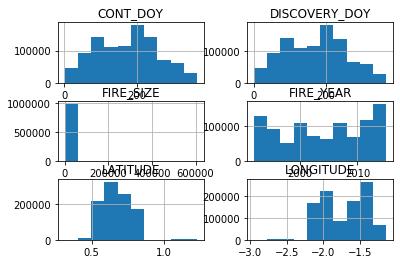

In [11]:
#check the distribution of numeric variables
data.hist()

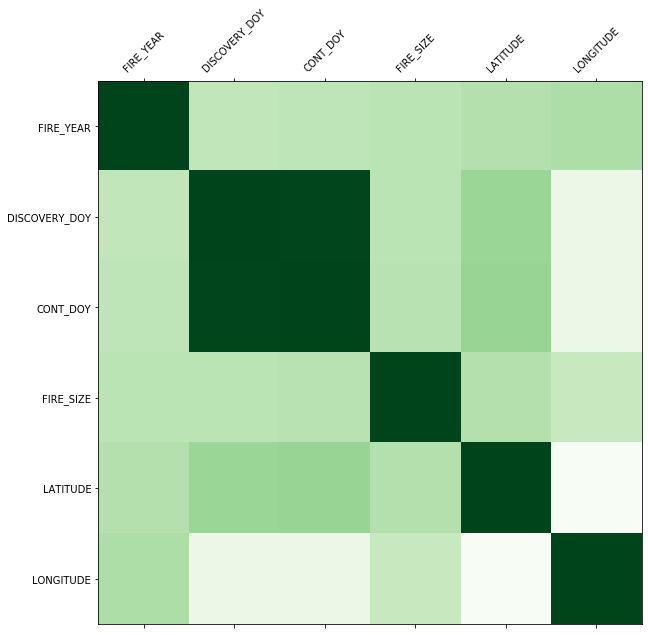

In [12]:
#check for multicollinearity of variables
def plot_corr(df,size=10):
    corr = df.corr()  #the default method is pearson
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr,cmap=plt.cm.Greens)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)    
    plt.show()
plot_corr(data, size=10)

In [13]:
data.describe()

,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,TOTAL_DAYS
count,988934.000000,988934.000000,988934.000000,988934.000000,988934.000000,988934.000000,988934
mean,2004.164514,171.566724,172.656766,119.268098,0.671796,-1.720978,1 days 05:36:33.612920
std,7.355631,83.778740,84.320348,3374.636111,0.101730,0.292990,15 days 14:51:12.093534
min,1992.000000,1.000000,1.000000,0.000100,0.313107,-2.947338,0 days 00:00:00
25%,1997.000000,102.000000,102.000000,0.100000,0.590609,-1.982929,0 days 00:00:00
50%,2005.000000,180.000000,181.000000,0.500000,0.654818,-1.665366,0 days 00:00:00
75%,2011.000000,230.000000,232.000000,3.000000,0.751029,-1.455107,0 days 00:00:00
max,2015.000000,366.000000,366.000000,606945.000000,1.227501,-1.138949,4018 days 00:00:00


In [14]:
print(data.dtypes)

UNIT_NAME                 object
FIRE_YEAR                  int64
DISCOVERY_DOY              int64
CAUSE_DESCR               object
CONT_DOY                 float64
FIRE_SIZE                float64
FIRE_CLASS                object
LATITUDE                 float64
LONGITUDE                float64
STATE                     object
Shape                     object
DISC_DATE         datetime64[ns]
CONTAIN_DATE      datetime64[ns]
TOTAL_DAYS       timedelta64[ns]
dtype: object


In [8]:
# converting total days format from timedelta to integer
data['TOTAL_DAYS']=data['TOTAL_DAYS'].apply(lambda x: x.days)

In [9]:
# dividing the days in number of bins to convert to categories small , medium, large and xlarge
data["DAY_CATEGORY"]=pd.cut(data["TOTAL_DAYS"], bins=[-1,3,5,10,500],labels=['small','medium','large','xlarge'])

In [10]:
#Encode CAUSE_DESCR with value between 0 and n_classes-1 for being a target variable
le = preprocessing.LabelEncoder()
le.fit(data['CAUSE_DESCR'])
list(le.classes_)
data['T_CAUSE_DESCR']=le.transform(data['CAUSE_DESCR'])

LabelEncoder()

['Arson',
 'Campfire',
 'Children',
 'Debris Burning',
 'Equipment Use',
 'Fireworks',
 'Lightning',
 'Miscellaneous',
 'Missing/Undefined',
 'Powerline',
 'Railroad',
 'Smoking',
 'Structure']

In [11]:
#Encode FIRE_CLASS with value between 0 and n_classes-1 for being a target variable
le.fit(data['FIRE_CLASS'])
list(le.classes_)
data['T_FIRE_CLASS']=le.transform(data['FIRE_CLASS'])

LabelEncoder()

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [12]:
# Create dummy variables for FIRE_CLASS and DAY_CATEGORY
data = pd.get_dummies(data, columns=['FIRE_CLASS','DAY_CATEGORY'], drop_first=True)

In [13]:
data.head()

,UNIT_NAME,FIRE_YEAR,DISCOVERY_DOY,CAUSE_DESCR,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,Shape,DISC_DATE,CONTAIN_DATE,TOTAL_DAYS,T_CAUSE_DESCR,T_FIRE_CLASS,FIRE_CLASS_B,FIRE_CLASS_C,FIRE_CLASS_D,FIRE_CLASS_E,FIRE_CLASS_F,FIRE_CLASS_G,DAY_CATEGORY_medium,DAY_CATEGORY_large,DAY_CATEGORY_xlarge
0,Plumas National Forest,2005,33,Miscellaneous,33.0,0.10,0.698777,-2.111950,CA,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,2005-02-02,2005-02-02,0,7,0,0,0,0,0,0,0,0,0,0
1,Eldorado National Forest,2004,133,Lightning,133.0,0.25,0.679510,-2.101454,CA,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,2004-05-12,2004-05-12,0,6,0,0,0,0,0,0,0,0,0,0
2,Eldorado National Forest,2004,152,Debris Burning,152.0,0.10,0.680402,-2.107233,CA,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,2004-05-31,2004-05-31,0,3,0,0,0,0,0,0,0,0,0,0
3,Eldorado National Forest,2004,180,Lightning,185.0,0.10,0.672984,-2.092882,CA,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,2004-06-28,2004-07-03,5,6,0,0,0,0,0,0,0,1,0,0
4,Eldorado National Forest,2004,180,Lightning,185.0,0.10,0.672984,-2.093227,CA,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,2004-06-28,2004-07-03,5,6,0,0,0,0,0,0,0,1,0,0


# Training and Test Datasets

### 1. Predict the cause of a fire wildfire given date, location, total number of days fire contained and size

In [14]:
#Since we'll be using supervised learning we need to create training and test datasets
pd.options.mode.chained_assignment = None  # default='warn'

# Define our dependent variable
y_column = 'T_CAUSE_DESCR'
y = data[y_column]
# Define our independent variables
x_columns = ['FIRE_YEAR','LATITUDE','LONGITUDE','FIRE_CLASS_B','FIRE_CLASS_C','FIRE_CLASS_D','FIRE_CLASS_E','FIRE_CLASS_F',
            'FIRE_CLASS_G','DAY_CATEGORY_medium','DAY_CATEGORY_large','DAY_CATEGORY_xlarge']
X = data[x_columns]
# Add an intercept term to the independent variables. This is needed in order to include the constant term from
# linear regression equation.
X['intercept'] = 1
# Split our data into training and test data sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Put some of the classes together and created 4 classes

In [15]:
#4 classes are: natural, accidental, malicious and other
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    elif cat in malicious:
        cause = 3
    else:
        cause = 4
    return cause
     

data['R_CAUSE_DESCR'] = data['CAUSE_DESCR'].apply(lambda x: set_label(x))

# Since we'll be using supervised learning we need to create training and test datasets
# Define our dependent variable as refined cause description (R_CAUSE_DESCR)
y_column = 'R_CAUSE_DESCR'
y = data[y_column]
# Define our independent variables
x_columns = ['FIRE_YEAR','LATITUDE','LONGITUDE','FIRE_CLASS_B','FIRE_CLASS_C','FIRE_CLASS_D','FIRE_CLASS_E','FIRE_CLASS_F',
            'FIRE_CLASS_G','DAY_CATEGORY_medium','DAY_CATEGORY_large','DAY_CATEGORY_xlarge']
X = data[x_columns]
# Add an intercept term to the independent variables. This is needed in order to include the constant term from
# linear regression equation.
X['intercept'] = 1
# Split our data into training and test data sets 30% for testing, 70% for training
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [16]:
# Create dummy variables for R_CAUSE_DESCR
data = pd.get_dummies(data, columns=['R_CAUSE_DESCR'], drop_first=True)

In [17]:
data.head()

,UNIT_NAME,FIRE_YEAR,DISCOVERY_DOY,CAUSE_DESCR,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,Shape,DISC_DATE,CONTAIN_DATE,TOTAL_DAYS,T_CAUSE_DESCR,T_FIRE_CLASS,FIRE_CLASS_B,FIRE_CLASS_C,FIRE_CLASS_D,FIRE_CLASS_E,FIRE_CLASS_F,FIRE_CLASS_G,DAY_CATEGORY_medium,DAY_CATEGORY_large,DAY_CATEGORY_xlarge,R_CAUSE_DESCR_2,R_CAUSE_DESCR_3,R_CAUSE_DESCR_4
0,Plumas National Forest,2005,33,Miscellaneous,33.0,0.10,0.698777,-2.111950,CA,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,2005-02-02,2005-02-02,0,7,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Eldorado National Forest,2004,133,Lightning,133.0,0.25,0.679510,-2.101454,CA,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,2004-05-12,2004-05-12,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Eldorado National Forest,2004,152,Debris Burning,152.0,0.10,0.680402,-2.107233,CA,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,2004-05-31,2004-05-31,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Eldorado National Forest,2004,180,Lightning,185.0,0.10,0.672984,-2.092882,CA,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,2004-06-28,2004-07-03,5,6,0,0,0,0,0,0,0,1,0,0,0,0,0
4,Eldorado National Forest,2004,180,Lightning,185.0,0.10,0.672984,-2.093227,CA,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,2004-06-28,2004-07-03,5,6,0,0,0,0,0,0,0,1,0,0,0,0,0


### 2. Predict the size of a fire given date, location, total number of days fire contained and cause

In [18]:
#Since we'll be using supervised learning we need to create training and test datasets
pd.options.mode.chained_assignment = None  # default='warn'

# Define our dependent variable
y_column = 'FIRE_SIZE'
y = data[y_column]
# Define our independent variables
x_columns = ['FIRE_YEAR','LATITUDE','LONGITUDE','DAY_CATEGORY_medium','DAY_CATEGORY_large','DAY_CATEGORY_xlarge','R_CAUSE_DESCR_2'
            ,'R_CAUSE_DESCR_3','R_CAUSE_DESCR_4']
X = data[x_columns]
# Add an intercept term to the independent variables. This is needed in order to include the constant term from
# linear regression equation.
X['intercept'] = 1
# Split our data into training and test data sets 30% for testing, 70% for training
X3_train, X3_test, y3_train, y3_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Use fire class (categorical variable) instead of fire size (continuous variable)

In [19]:
#Since we'll be using supervised learning we need to create training and test datasets
pd.options.mode.chained_assignment = None  # default='warn'

# Define our dependent variable
y_column = 'T_FIRE_CLASS'
y = data[y_column]
# Define our independent variables
x_columns = ['FIRE_YEAR','LATITUDE','LONGITUDE','DAY_CATEGORY_medium','DAY_CATEGORY_large','DAY_CATEGORY_xlarge','R_CAUSE_DESCR_2'
            ,'R_CAUSE_DESCR_3','R_CAUSE_DESCR_4']
X = data[x_columns]
# Add an intercept term to the independent variables. This is needed in order to include the constant term from
# linear regression equation.
X['intercept'] = 1
# Split our data into training and test data sets 30% for testing, 70% for training
X4_train, X4_test, y4_train, y4_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Linear Regression

### Can we use linear regression to predict the cause of a fire wildfire, given size, location, date and total number of days fire contained?

In [27]:
# Train and evaluate the model with T_CAUSE_DESCR variable
#check the model summary
model = sm.OLS(endog=y1_train, exog=X1_train)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:          T_CAUSE_DESCR   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2382.
Date:                Wed, 22 Apr 2020   Prob (F-statistic):               0.00
Time:                        17:11:26   Log-Likelihood:            -1.9509e+06
No. Observations:              791147   AIC:                         3.902e+06
Df Residuals:                  791134   BIC:                         3.902e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
FIRE_YEAR               0.0019    

In [28]:
# Train and evaluate the model with R_CAUSE_DESCR variable
#check the model summary
model = sm.OLS(endog=y2_train, exog=X2_train)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:          R_CAUSE_DESCR   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     7370.
Date:                Wed, 22 Apr 2020   Prob (F-statistic):               0.00
Time:                        17:12:19   Log-Likelihood:            -9.9600e+05
No. Observations:              692253   AIC:                         1.992e+06
Df Residuals:                  692240   BIC:                         1.992e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
FIRE_YEAR               0.0053    

### Can we use linear regression to predict the size of a fire wildfire, given cause of a fire wildfire, location, date and total number of days fire contained?

In [29]:
# Train and evaluate the model with FIRE_SIZE variable
#check the model summary
model = sm.OLS(endog=y3_train, exog=X3_train)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              FIRE_SIZE   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2005.
Date:                Wed, 22 Apr 2020   Prob (F-statistic):               0.00
Time:                        17:12:26   Log-Likelihood:            -6.6014e+06
No. Observations:              692253   AIC:                         1.320e+07
Df Residuals:                  692243   BIC:                         1.320e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
FIRE_YEAR              -1.7609    

In [30]:
# Train and evaluate the model with T_FIRE_CLASS variable
#check the model summary
model = sm.OLS(endog=y4_train, exog=X4_train)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:           T_FIRE_CLASS   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     8226.
Date:                Wed, 22 Apr 2020   Prob (F-statistic):               0.00
Time:                        17:12:30   Log-Likelihood:            -8.7024e+05
No. Observations:              692253   AIC:                         1.740e+06
Df Residuals:                  692243   BIC:                         1.741e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
FIRE_YEAR              -0.0031    

# Decision Tree

In [31]:
def train_score_regressor(sklearn_regressor, X_train, y_train, X_test, y_test, model_parameters, print_oob_score=False):
    # initializing the sklearn regressor 
    regressor = sklearn_regressor(**model_parameters)  
    # training the algorithm using the X_train dataset of features and y_train, the associated target features
    regressor.fit(X_train, y_train)
    y_pred1 = regressor.predict (X_train)
    y_pred2 = regressor.predict (X_test)
   
    # calculating the score of the predictive power on the training and testing dataset.
    print ('Train score: %.3f' % r2_score(y_train, y_pred1))
    print ('Test score: %.3f' % r2_score(y_test, y_pred2))
    # results
    return regressor

### Can we use Decision Tree to predict the cause of a fire wildfire, given size, location, date and total number of days fire contained?

In [32]:
# Train and evaluate the model with T_CAUSE_DESCR variable
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X1_train, 
                                          y_train=y1_train, 
                                          X_test=X1_test, 
                                          y_test=y1_test, 
                                          model_parameters={'random_state':42})

Train score: 0.979
Test score: -0.185


#### Parameter tuning

In [33]:
parameters = {"max_depth":8,
              'random_state':42}

# Train and evaluate the model
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X1_train, 
                                          y_train=y1_train, 
                                          X_test=X1_test, 
                                          y_test=y1_test, 
                                          model_parameters=parameters)

Train score: 0.235
Test score: 0.228


In [34]:
parameters = {"max_depth":[6,7,8],
              "max_leaf_nodes":[4,5,6]}
decision_regressor= DecisionTreeRegressor(random_state=42)

# initializing GridSearch and then fit
regressor=GridSearchCV(decision_regressor,parameters)
regressor.fit(X1_train, y1_train)
regressor.best_estimator_.get_params()

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=42, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [6, 7, 8], 'max_leaf_nodes': [4, 5, 6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': 6,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}

In [35]:
parameters = {"max_depth":[4,5,6],
              "max_leaf_nodes":[6,7,8],
              'min_samples_leaf': [1,2,3],
              'min_samples_split': [2,3,4]}
decision_regressor= DecisionTreeRegressor(random_state=42)

# initializing GridSearch and then fit
regressor=GridSearchCV(decision_regressor,parameters)
regressor.fit(X1_train, y1_train)
regressor.best_estimator_.get_params()

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=42, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [4, 5, 6], 'max_leaf_nodes': [6, 7, 8],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]},
       

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': 8,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}

In [36]:
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X1_train, 
                                          y_train=y1_train, 
                                          X_test=X1_test, 
                                          y_test=y1_test, 
                                          model_parameters=regressor.best_estimator_.get_params())

Train score: 0.118
Test score: 0.115


In [37]:
# Train and evaluate the model with R_CAUSE_DESCR variable
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X2_train, 
                                          y_train=y2_train, 
                                          X_test=X2_test, 
                                          y_test=y2_test, 
                                          model_parameters={'random_state':42})

Train score: 0.988
Test score: 0.070


### Can we use Decision Tree to predict the size of a fire wildfire, given cause of a fire wildfire, location, date and total number of days fire contained?

In [38]:
# Train and evaluate the model with T_FIRE_SIZE variable
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X3_train, 
                                          y_train=y3_train, 
                                          X_test=X3_test, 
                                          y_test=y3_test, 
                                          model_parameters={'random_state':42})

Train score: 0.991
Test score: -0.877


#### Parameter tuning

In [39]:
parameters = {"max_depth":8,
              'random_state':42}

# Train and evaluate the model
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X3_train, 
                                          y_train=y3_train, 
                                          X_test=X3_test, 
                                          y_test=y3_test, 
                                          model_parameters=parameters)

Train score: 0.343
Test score: -0.148


In [40]:
parameters = {"max_depth":[6,7,8],
              "max_leaf_nodes":[4,5,6]}
decision_regressor= DecisionTreeRegressor(random_state=42)

# initializing GridSearch and then fit
regressor=GridSearchCV(decision_regressor,parameters)
regressor.fit(X3_train, y3_train)
regressor.best_estimator_.get_params()

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=42, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [6, 7, 8], 'max_leaf_nodes': [4, 5, 6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': 5,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}

In [41]:
parameters = {"max_depth":[4,5,6],
              "max_leaf_nodes":[3,4,5],
              'min_samples_leaf': [1,2,3],
              'min_samples_split': [2,3,4]}
decision_regressor= DecisionTreeRegressor(random_state=42)

# initializing GridSearch and then fit
regressor=GridSearchCV(decision_regressor,parameters)
regressor.fit(X3_train, y3_train)
regressor.best_estimator_.get_params()

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=42, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [4, 5, 6], 'max_leaf_nodes': [3, 4, 5],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]},
       

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': 3,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}

In [42]:
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X3_train, 
                                          y_train=y3_train, 
                                          X_test=X3_test, 
                                          y_test=y3_test, 
                                          model_parameters=regressor.best_estimator_.get_params())

Train score: 0.047
Test score: 0.059


In [43]:
# Train and evaluate the model with FIRE_CLASS variable
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X4_train, 
                                          y_train=y4_train, 
                                          X_test=X4_test, 
                                          y_test=y4_test, 
                                          model_parameters={'random_state':42})

Train score: 0.984
Test score: -0.140


# Random Forest

### Can we use Random Forest to predict the cause of a fire wildfire, given size, location, date and total number of days fire contained?

In [92]:
# Train and evaluate the model with T_CAUSE_DESCR variable
clf_rf = ske.RandomForestClassifier(n_estimators=50)
clf_rf1 = clf_rf.fit(X1_train,y1_train)
print(clf_rf1.score(X1_train,y1_train))
print(clf_rf1.score(X1_test,y1_test))

0.9854034711627548
0.5730154155733188


In [93]:
importances=clf_rf1.feature_importances_
names = ['FIRE_YEAR','LATITUDE','LONGITUDE','FIRE_CLASS_B','FIRE_CLASS_C','FIRE_CLASS_D','FIRE_CLASS_E','FIRE_CLASS_F',
            'FIRE_CLASS_G','DAY_CATEGORY_medium','DAY_CATEGORY_large','DAY_CATEGORY_xlarge']
for name, importance in zip(names, importances):
    print(name, "=", importance)

FIRE_YEAR = 0.09501393090147034
LATITUDE = 0.3928233725771622
LONGITUDE = 0.4871066756018927
FIRE_CLASS_B = 0.008964574870874552
FIRE_CLASS_C = 0.005024762082273468
FIRE_CLASS_D = 0.0015305987193792929
FIRE_CLASS_E = 0.001220654062811628
FIRE_CLASS_F = 0.0008235630552206893
FIRE_CLASS_G = 0.0005351686650544162
DAY_CATEGORY_medium = 0.0018333168446423894
DAY_CATEGORY_large = 0.001795175726899443
DAY_CATEGORY_xlarge = 0.003328206892318756


<BarContainer object of 13 artists>

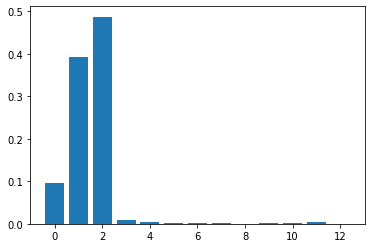

In [94]:
# plot feature importance
pyplot.bar([x for x in range(len(importances))], importances)
pyplot.show()

In [21]:
# Train and evaluate the model with R_CAUSE_DESCR variable
clf_rf = ske.RandomForestClassifier(n_estimators=50)
clf_rf2 = clf_rf.fit(X2_train,y2_train)
print(clf_rf2.score(X2_train,y2_train))
print(clf_rf2.score(X2_test,y2_test))

0.989486502767052
0.6722944846484945


In [96]:
importances=clf_rf2.feature_importances_
names = ['FIRE_YEAR','LATITUDE','LONGITUDE','FIRE_CLASS_B','FIRE_CLASS_C','FIRE_CLASS_D','FIRE_CLASS_E','FIRE_CLASS_F',
            'FIRE_CLASS_G','DAY_CATEGORY_medium','DAY_CATEGORY_large','DAY_CATEGORY_xlarge']
for name, importance in zip(names, importances):
    print(name, "=", importance)

FIRE_YEAR = 0.0953115804884331
LATITUDE = 0.3846507680998266
LONGITUDE = 0.4924355045896624
FIRE_CLASS_B = 0.008030682863362172
FIRE_CLASS_C = 0.005379948355852182
FIRE_CLASS_D = 0.0020225417107697123
FIRE_CLASS_E = 0.0012542858438267899
FIRE_CLASS_F = 0.0009726600951286085
FIRE_CLASS_G = 0.0006049553599124314
DAY_CATEGORY_medium = 0.0023387440518781197
DAY_CATEGORY_large = 0.0022145389189085142
DAY_CATEGORY_xlarge = 0.0047837896224392565


<BarContainer object of 13 artists>

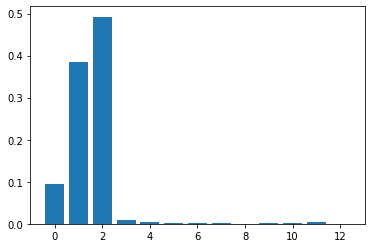

In [97]:
# plot feature importance
pyplot.bar([x for x in range(len(importances))], importances)
pyplot.show()

In [22]:
y2_pred = clf_rf.fit(X2_train, y2_train).predict(X2_test)
cm = confusion_matrix(y_true=y2_test,y_pred=y2_pred)
print(cm)

[[54007  9337  1176  3891]
 [11054 79555 10811 12569]
 [ 1627 14180 23178  4762]
 [ 6014 17260  4082 43178]]


Text(0, 0, '0.7894490652088114')

Text(1, 0, '0.13648389878820658')

Text(2, 0, '0.01719021794740612')

Text(3, 0, '0.05687681805557586')

Text(0, 1, '0.09697426944705191')

Text(1, 1, '0.6979182201791401')

Text(2, 1, '0.09484248480116503')

Text(3, 1, '0.11026502557264298')

Text(0, 2, '0.03719112167691499')

Text(1, 2, '0.3241365122179807')

Text(2, 2, '0.5298191876014355')

Text(3, 2, '0.10885317850366882')

Text(0, 3, '0.08526384438710409')

Text(1, 3, '0.24470468143023222')

Text(2, 3, '0.05787279893384751')

Text(3, 3, '0.6121586752488162')

Text(0.5, 0, 'predicted label')

Text(0, 0.5, 'true label')

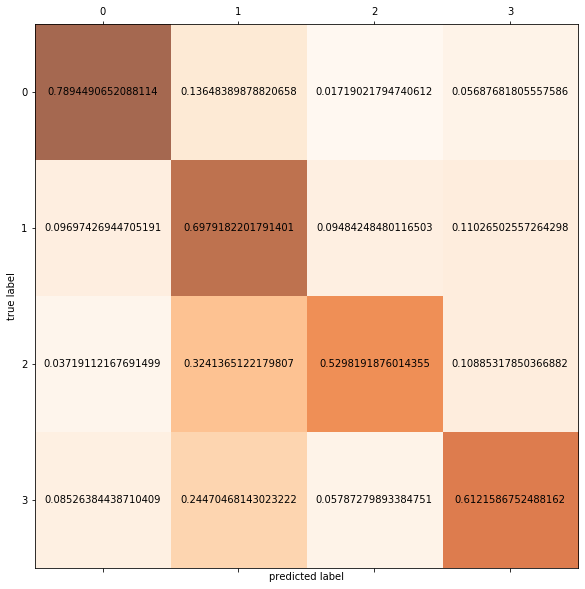

In [23]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig,ax = plt.subplots(figsize=(10,10))
ax.matshow(cmn,cmap=plt.cm.Oranges,alpha=0.7)
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        ax.text(x=j,y=i,s=cmn[i,j],va='center',ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

### Can we use Random Forest to predict the size of a fire wildfire, given cause of a fire wildfire, location, date and total number of days fire contained?

In [24]:
# Train and evaluate the model with T_FIRE_CLASS variable
clf_rf3 = clf_rf.fit(X4_train,y4_train)
print(clf_rf3.score(X4_train,y4_train))
print(clf_rf3.score(X4_test,y4_test))

0.9834901401655175
0.6057044434931795


In [99]:
importances=clf_rf3.feature_importances_
names = ['FIRE_YEAR','LATITUDE','LONGITUDE','DAY_CATEGORY_medium','DAY_CATEGORY_large','DAY_CATEGORY_xlarge','R_CAUSE_DESCR_2'
            ,'R_CAUSE_DESCR_3','R_CAUSE_DESCR_4']
for name, importance in zip(names, importances):
    print(name, "=", importance)

FIRE_YEAR = 0.08008396370169059
LATITUDE = 0.415365466346432
LONGITUDE = 0.4766081553788395
DAY_CATEGORY_medium = 0.002579876397292375
DAY_CATEGORY_large = 0.002340367919782412
DAY_CATEGORY_xlarge = 0.003966022760281534
R_CAUSE_DESCR_2 = 0.005535966402244128
R_CAUSE_DESCR_3 = 0.008524920576527895
R_CAUSE_DESCR_4 = 0.004995260516909594


<BarContainer object of 10 artists>

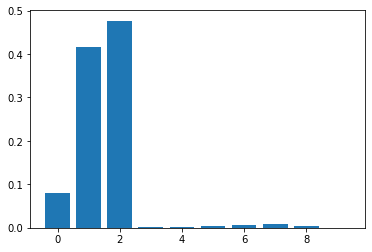

In [100]:
# plot feature importance
pyplot.bar([x for x in range(len(importances))], importances)
pyplot.show()

In [25]:
y4_pred = clf_rf.fit(X4_train, y4_train).predict(X4_test)
cm = confusion_matrix(y_true=y4_test,y_pred=y4_pred)
print(cm)

[[91109 32432  2142   221   151   110    42]
 [37841 80644  9343   600   315   163    82]
 [ 5084 18190  6932   615   305   141    81]
 [  902  2053  1127   309   158    95    47]
 [  575   978   538   180   177   137    86]
 [  369   537   301   112   144   184   135]
 [  173   206   122    50    82   105   256]]


Text(0, 0, '0.7219013208459119')

Text(1, 0, '0.2569746527530169')

Text(2, 0, '0.01697211723596948')

Text(3, 0, '0.0017510914608539938')

Text(4, 0, '0.0011964471067373442')

Text(5, 0, '0.0008715839850404494')

Text(6, 0, '0.00033278661246998977')

Text(0, 1, '0.293368375352746')

Text(1, 1, '0.6252054454677954')

Text(2, 1, '0.07243309455143114')

Text(3, 1, '0.0046515954972555585')

Text(4, 1, '0.0024420876360591683')

Text(5, 1, '0.0012636834434210935')

Text(6, 1, '0.000635718051291593')

Text(0, 2, '0.16217940538471354')

Text(1, 2, '0.5802603036876356')

Text(2, 2, '0.22113053464335844')

Text(3, 2, '0.01961847645782825')

Text(4, 2, '0.00972948832461401')

Text(5, 2, '0.004497894602526477')

Text(6, 2, '0.002583896899323721')

Text(0, 3, '0.19228309528885099')

Text(1, 3, '0.43764655723726287')

Text(2, 3, '0.24024728202941803')

Text(3, 3, '0.0658708164570454')

Text(4, 3, '0.03368151780004264')

Text(5, 3, '0.020251545512683863')

Text(6, 3, '0.010019185674696228')

Text(0, 4, '0.21527517783601646')

Text(1, 4, '0.3661549981280419')

Text(2, 4, '0.20142268813178585')

Text(3, 4, '0.06739049045301385')

Text(4, 4, '0.06626731561213028')

Text(5, 4, '0.0512916510670161')

Text(6, 4, '0.03219767877199551')

Text(0, 5, '0.20707070707070707')

Text(1, 5, '0.30134680134680136')

Text(2, 5, '0.16891133557800225')

Text(3, 5, '0.06285072951739619')

Text(4, 5, '0.08080808080808081')

Text(5, 5, '0.10325476992143659')

Text(6, 5, '0.07575757575757576')

Text(0, 6, '0.17404426559356137')

Text(1, 6, '0.20724346076458752')

Text(2, 6, '0.1227364185110664')

Text(3, 6, '0.05030181086519115')

Text(4, 6, '0.08249496981891348')

Text(5, 6, '0.1056338028169014')

Text(6, 6, '0.2575452716297787')

Text(0.5, 0, 'predicted label')

Text(0, 0.5, 'true label')

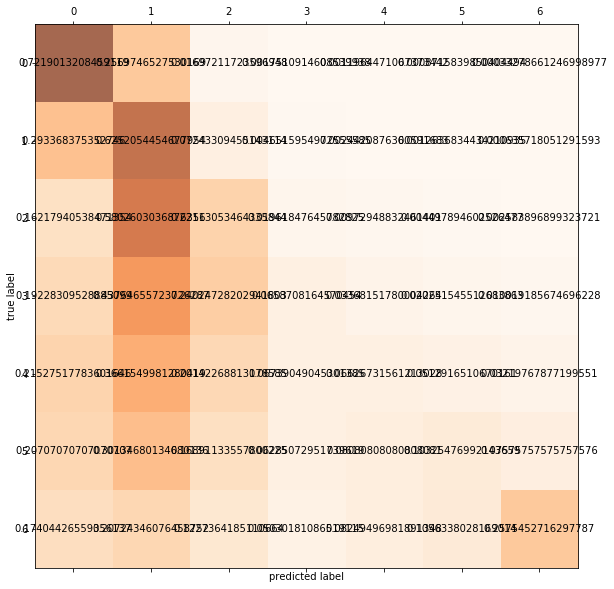

In [26]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig,ax = plt.subplots(figsize=(10,10))
ax.matshow(cmn,cmap=plt.cm.Oranges,alpha=0.7)
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        ax.text(x=j,y=i,s=cmn[i,j],va='center',ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

# Naive Bayes

### Can we use Naive Bayes to predict the cause of a fire wildfire, given size, location, date and total number of days fire contained?

In [66]:
#Naive Bayes Classifier
# Train and evaluate the model with T_CAUSE_DSCR variable
gnb = GaussianNB()
gnb1 = gnb.fit(X1_train,y1_train)
#Calculating the score of the predictive power on the training and testing dataset.
print('Test score: %.3f' % gnb1.score(X1_train,y1_train))
print('Test score: %.3f' % gnb1.score(X1_test,y1_test))

Test score: 0.200
Test score: 0.200


In [76]:
#Naive Bayes Classifier
# Train and evaluate the model with R_CAUSE_DESCR variable
gnb2 = gnb.fit(X2_train,y2_train)
#Calculating the score of the predictive power on the training and testing dataset.
print('Test score: %.3f' % gnb2.score(X2_train,y2_train))
print('Test score: %.3f' % gnb2.score(X2_test,y2_test))

Test score: 0.396
Test score: 0.395


### Can we use Naive Bayes to predict the size of a fire wildfire, given cause of a fire wildfire, location, date and total number of days fire contained?

In [77]:
#Naive Bayes Classifier
# Train and evaluate the model with T_FIRE_CLASS variable
gnb3 = gnb.fit(X4_train,y4_train)
#Calculating the score of the predictive power on the training and testing dataset.
print('Test score: %.3f' % gnb3.score(X4_train,y4_train))
print('Test score: %.3f' % gnb3.score(X4_test,y4_test))

Test score: 0.553
Test score: 0.555
